In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('PedInf.txt', delimiter='\t')

# Create edge list
edges = []
for _, row in df.iterrows():
    if pd.notna(row['MaleParent']):
        edges.append((row['MaleParent'], row['LineName']))
    if pd.notna(row['FemaleParent']):
        edges.append((row['FemaleParent'], row['LineName']))

edges_df = pd.DataFrame(edges, columns=["Parent", "Child"])

# Save edges to CSV for loading into cuGraph
edges_df.to_csv("edges.csv", index=False)


In [2]:
import cudf
import cugraph

# Load the edges into cuDF
edges_df = cudf.read_csv("edges.csv")

# Create a directed graph
G = cugraph.Graph(directed=True)
G.from_cudf_edgelist(edges_df, source='Parent', destination='Child')

# Perform PageRank analysis
pagerank_scores = cugraph.pagerank(G)

# Convert PageRank scores to a pandas DataFrame for easier manipulation
pagerank_df = pagerank_scores.to_pandas()

# Rank individuals by their PageRank score
pagerank_df = pagerank_df.sort_values(by='pagerank', ascending=False)

# Display the top-ranked individuals
print(pagerank_df)


       pagerank       vertex
23730  0.000204     H49-0005
27864  0.000169    CL89-5457
29965  0.000165     H50-0723
15296  0.000160       B59162
27078  0.000156    CL79-2243
...         ...          ...
38355  0.000020     Taiwan68
38356  0.000020    CP13-4524
38357  0.000020        01P07
38358  0.000020  CPCL97-2730
45805  0.000020    CL92-3120

[46813 rows x 2 columns]


/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(
/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


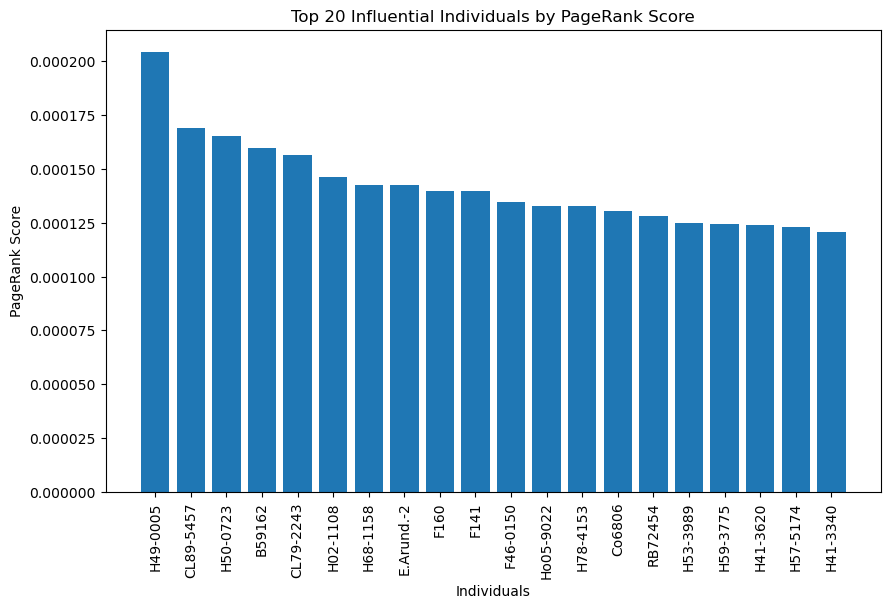

In [7]:
import matplotlib.pyplot as plt

# Plot PageRank scores
plt.figure(figsize=(10, 6))
plt.bar(pagerank_df['vertex'].astype(str).head(20), pagerank_df['pagerank'].head(20))
plt.xlabel('Individuals')
plt.ylabel('PageRank Score')
plt.title('Top 20 Influential Individuals by PageRank Score')
plt.xticks(rotation=90)
plt.show()


In [3]:
import cudf
import cugraph

# Load the edges into cuDF
edges_df = cudf.read_csv("edges.csv")

# Create a directed graph
G = cugraph.Graph(directed=True)
G.from_cudf_edgelist(edges_df, source='Parent', destination='Child')

# Compute various centrality measures

# Degree Centrality
degree_centrality = G.degree()

# Betweenness Centrality
betweenness_centrality = cugraph.betweenness_centrality(G)

# Katz Centrality
katz_centrality = cugraph.katz_centrality(G)

# PageRank
pagerank_scores = cugraph.pagerank(G)

# Eigenvector Centrality
eigenvector_centrality = cugraph.eigenvector_centrality(G)

# Merge centrality measures into a single DataFrame
centrality_df = cudf.DataFrame()
centrality_df['vertex'] = degree_centrality['vertex']
centrality_df['degree_centrality'] = degree_centrality['degree']
centrality_df = centrality_df.merge(betweenness_centrality, on='vertex', how='left')
centrality_df = centrality_df.merge(katz_centrality, on='vertex', how='left')
centrality_df = centrality_df.merge(pagerank_scores, on='vertex', how='left')
centrality_df = centrality_df.merge(eigenvector_centrality, on='vertex', how='left')

# Convert to pandas DataFrame for easier manipulation and display
centrality_df = centrality_df.to_pandas()

# Sort by PageRank as an example
centrality_df = centrality_df.sort_values(by='pagerank', ascending=False)

# Display the top-ranked individuals by PageRank
print(centrality_df.head(20))


/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(
/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/centrality/katz_centrality.py:121: UserWarning: Katz centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/centrality/eigenvector_centrality.py:88: UserWar

           vertex  degree_centrality  betweenness_centrality  katz_centrality  \
26297    H49-0005                  4            5.454864e-08         0.004622   
14472   CL89-5457                  7            1.588417e-05         0.004622   
11790    H50-0723                  4            4.928544e-08         0.004622   
33404      B59162                  2            0.000000e+00         0.004622   
1068    CL79-2243                  3            1.501894e-05         0.004622   
26677    H02-1108                  3            4.563467e-10         0.004622   
12719    H68-1158                  2            0.000000e+00         0.004622   
44206  E.Arund.-2                  2            0.000000e+00         0.004620   
3357         F160                 72            1.128545e-06         0.004622   
27394        F141                  3            3.470516e-07         0.004622   
40082    F46-0150                  3            2.904647e-07         0.004622   
3185    Ho05-9022           

In [4]:
centrality_df.to_csv('centrality_df.csv', index=False)